# Dogs vs Cats Image Classification

### Setup

In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Activation, Conv2D, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dropout, LeakyReLU
from tensorflow.keras.applications import Xception
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Rescaling

### Download datasets from Kaggle

In [ ]:
from google.colab import files
files.upload()

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

100% 814M/814M [00:42<00:00, 18.9MB/s]
100% 814M/814M [00:42<00:00, 19.9MB/s]


In [6]:
!unzip dogs-vs-cats-redux-kernels-edition.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [7]:
# unzip train and test data
!unzip -q train.zip -d kaggle
!unzip -q test.zip -d kaggle

### Generate image data for train data

In [7]:
images_train = []

for i in os.listdir('/content/kaggle/train/'):
    label = i.split('.')[0]
    if label == 'cat':
        label = 0
    else:
        label = 1
    img = cv2.imread('/content/kaggle/train/' + i, cv2.IMREAD_COLOR)
    img = cv2.resize(img,(150, 150), interpolation = cv2.INTER_CUBIC)
    images_train.append([np.array(img), np.array(label)])

In [9]:
# shuffles the order of the images
random.shuffle(images_train)

In [8]:
X = np.array([i[0] for i in images_train]).reshape(-1, 150, 150, 3)
y = np.array([i[1] for i in images_train])
X.shape, y.shape

((25000, 150, 150, 3), (25000,))

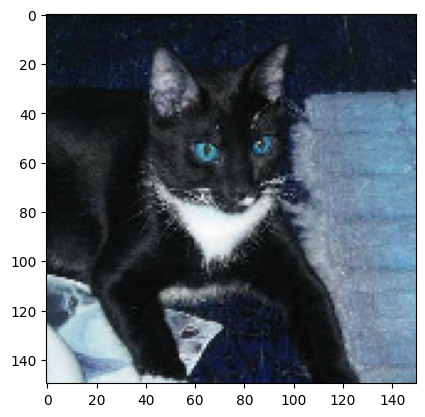

In [12]:
img=random.randint(0, 25000)
plt.imshow(X[img])

In [9]:
# Split train data into train and validation
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2, random_state=32)

### Compile Models
Build a model layer by layer, ResNet, Transfer learning with Exception

### 1. Customized Model

In [15]:
model = Sequential()

model.add(Conv2D(32, 3, 3, input_shape=(150, 150, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='LeakyReLU'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        3

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, validation_data=(X_validation, y_validation))
score = model.evaluate(X_validation, y_validation)
print('Random model validation accuracy:', score[1])

Epoch 1/20
625/625 [==============================] - 16s 12ms/step - loss: 0.6751 - accuracy: 0.5830 - val_loss: 0.6680 - val_accuracy: 0.5678
Epoch 2/20
625/625 [==============================] - 6s 10ms/step - loss: 0.6227 - accuracy: 0.6561 - val_loss: 0.6128 - val_accuracy: 0.6738
Epoch 3/20
625/625 [==============================] - 7s 10ms/step - loss: 0.5864 - accuracy: 0.6905 - val_loss: 0.5913 - val_accuracy: 0.6898
Epoch 4/20
625/625 [==============================] - 6s 10ms/step - loss: 0.5583 - accuracy: 0.7174 - val_loss: 0.5411 - val_accuracy: 0.7188
Epoch 5/20
625/625 [==============================] - 7s 11ms/step - loss: 0.5302 - accuracy: 0.7406 - val_loss: 0.5813 - val_accuracy: 0.7102
Epoch 6/20
625/625 [==============================] - 6s 9ms/step - loss: 0.5026 - accuracy: 0.7578 - val_loss: 0.4613 - val_accuracy: 0.7784
Epoch 7/20
625/625 [==============================] - 6s 10ms/step - loss: 0.4849 - accuracy: 0.7679 - val_loss: 0.4794 - val_accuracy: 0.7720

### 2. ResNet

In [18]:
model_res = Sequential()
model_res.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model_res.add(Dense(250, activation='relu'))
model_res.add(Dense(1, activation='sigmoid'))
model_res.layers[0].trainable = False
model_res.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 250)               512250    
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
Total params: 24100213 (91.94 MB)
Trainable params: 512501 (1.96 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [19]:
model_res.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_res.fit(X_train, y_train, epochs=20, validation_data=(X_validation, y_validation))
score = model_res.evaluate(X_validation, y_validation)
print('ResNet50 validation accuracy:', score[1])

Epoch 1/20
625/625 [==============================] - 50s 70ms/step - loss: 0.2641 - accuracy: 0.9512 - val_loss: 0.0939 - val_accuracy: 0.9638
Epoch 2/20
625/625 [==============================] - 42s 67ms/step - loss: 0.0793 - accuracy: 0.9693 - val_loss: 0.0814 - val_accuracy: 0.9650
Epoch 3/20
625/625 [==============================] - 43s 68ms/step - loss: 0.0702 - accuracy: 0.9717 - val_loss: 0.0797 - val_accuracy: 0.9676
Epoch 4/20
625/625 [==============================] - 41s 66ms/step - loss: 0.0620 - accuracy: 0.9767 - val_loss: 0.0810 - val_accuracy: 0.9674
Epoch 5/20
625/625 [==============================] - 40s 64ms/step - loss: 0.0591 - accuracy: 0.9769 - val_loss: 0.0795 - val_accuracy: 0.9672
Epoch 6/20
625/625 [==============================] - 40s 65ms/step - loss: 0.0478 - accuracy: 0.9823 - val_loss: 0.0863 - val_accuracy: 0.9664
Epoch 7/20
625/625 [==============================] - 40s 65ms/step - loss: 0.0464 - accuracy: 0.9826 - val_loss: 0.0814 - val_accuracy:

### 3. Xception

In [4]:
base_model = Xception(weights='imagenet', input_shape=(150, 150, 3), include_top=False)
base_model.trainable = False

inputs = Input(shape=(150, 150, 3))
scale_layer = Rescaling(scale=1 / 127.5, offset = -1)
x = scale_layer(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)
model_xcept = Model(inputs, outputs)
model_xcept.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 activation_1 (Activation)   (None, 2048)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

In [10]:
model_xcept.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_xcept.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))
score = model_xcept.evaluate(X_validation, y_validation)
print('Xception validation accuracy:', score[1])

Epoch 1/10
625/625 [==============================] - 59s 79ms/step - loss: 0.1211 - accuracy: 0.9523 - val_loss: 0.0904 - val_accuracy: 0.9624
Epoch 2/10
625/625 [==============================] - 47s 75ms/step - loss: 0.0913 - accuracy: 0.9636 - val_loss: 0.0977 - val_accuracy: 0.9638
Epoch 3/10
625/625 [==============================] - 46s 74ms/step - loss: 0.0875 - accuracy: 0.9653 - val_loss: 0.0858 - val_accuracy: 0.9660
Epoch 4/10
625/625 [==============================] - 47s 75ms/step - loss: 0.0851 - accuracy: 0.9671 - val_loss: 0.0829 - val_accuracy: 0.9684
Epoch 5/10
625/625 [==============================] - 47s 76ms/step - loss: 0.0806 - accuracy: 0.9675 - val_loss: 0.0848 - val_accuracy: 0.9676
Epoch 6/10
625/625 [==============================] - 46s 74ms/step - loss: 0.0782 - accuracy: 0.9693 - val_loss: 0.0815 - val_accuracy: 0.9690
Epoch 7/10
625/625 [==============================] - 49s 78ms/step - loss: 0.0781 - accuracy: 0.9690 - val_loss: 0.0857 - val_accuracy:

### Predict on test data

In [11]:
# prepare image data for test dataset
images_test = []

for i in tqdm(os.listdir('/content/kaggle/test/')):
    img_id = i.split('.')[0]
    img = cv2.imread('/content/kaggle/test/' + i, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150, 150))
    images_test.append([np.array(img), img_id])

100%|██████████| 12500/12500 [00:34<00:00, 359.14it/s]


### 1. Customized Model

In [ ]:
pred_list = []
id_list = []

for i in tqdm(images_test, disable=True):
    img_data = i[0]
    img_id = i[1]
    data = img_data.reshape(-1, 150, 150, 3)
    y_predict = model.predict([data])[0][0]
    id_list.append(img_id)
    pred_list.append(y_predict)

### 2. ResNet

In [ ]:
pred_list_res = []
id_list_res = []

for i in tqdm(images_test, disable=True):
    img_data = i[0]
    img_id = i[1]
    data = img_data.reshape(-1, 150, 150, 3)
    y_predict = model_res.predict([data])[0][0]
    id_list_res.append(img_id)
    pred_list_res.append(y_predict)

### 3. Xception

In [ ]:
pred_list_xcept = []
id_list_xcept = []

for i in images_test:
    img_data = i[0]
    img_id = i[1]
    data = img_data.reshape(-1, 150, 150, 3)
    y_predict = model_xcept.predict([data])[0][0]
    id_list_xcept.append(img_id)
    pred_list_xcept.append(y_predict)

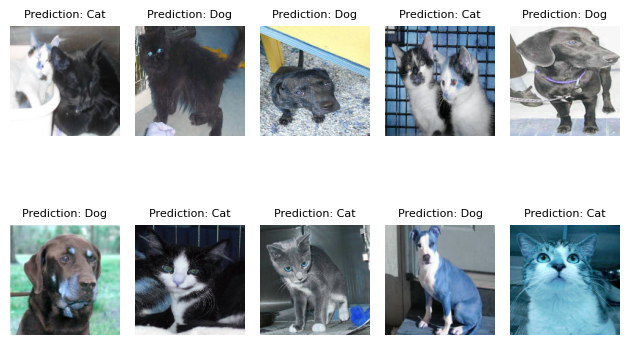

In [17]:
# print prediciton result using xception
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_test[i][0])

    if pred_list_xcept[i] > 0.5:
        label = 'Dog'
    else:
        label = 'Cat'

    plt.title(f'Prediction: {label}', fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# prepare submission data
submission_model1 = pd.DataFrame({'id': id_list , 'label': pred_list})
submission_res = pd.DataFrame({'id': id_list_res, 'label': pred_list_res})
submission_xcept = pd.DataFrame({'id': id_list_xcept, 'label': pred_list_xcept})

In [ ]:
submission_model1.head()

,id,label
0,2019,0.011345
1,7719,0.410253
2,6450,0.909784
3,6238,0.023524
4,11349,0.215783


In [ ]:
submission_res.head()

,id,label
0,2019,9.345485e-16
1,7719,9.999913e-01
2,6450,1.000000e+00
3,6238,6.092805e-10
4,11349,1.000000e+00


In [ ]:
submission_xcept.head()

,id,label
0,2019,0.000002
1,7719,0.999923
2,6450,0.994707
3,6238,0.000151
4,11349,0.999801


In [ ]:
# export to csv files
submission_model1.to_csv("submission_my_model.csv", index=False)
submission_res.to_csv("submission_ResNet.csv", index=False)
submission_xcept.to_csv("submission_Xception.csv", index=False)